In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import glob
%matplotlib inline


# Camera calibration and distortion correction

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

nx = 9
ny = 6
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

In [3]:
def get_camera_calibration(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist
    

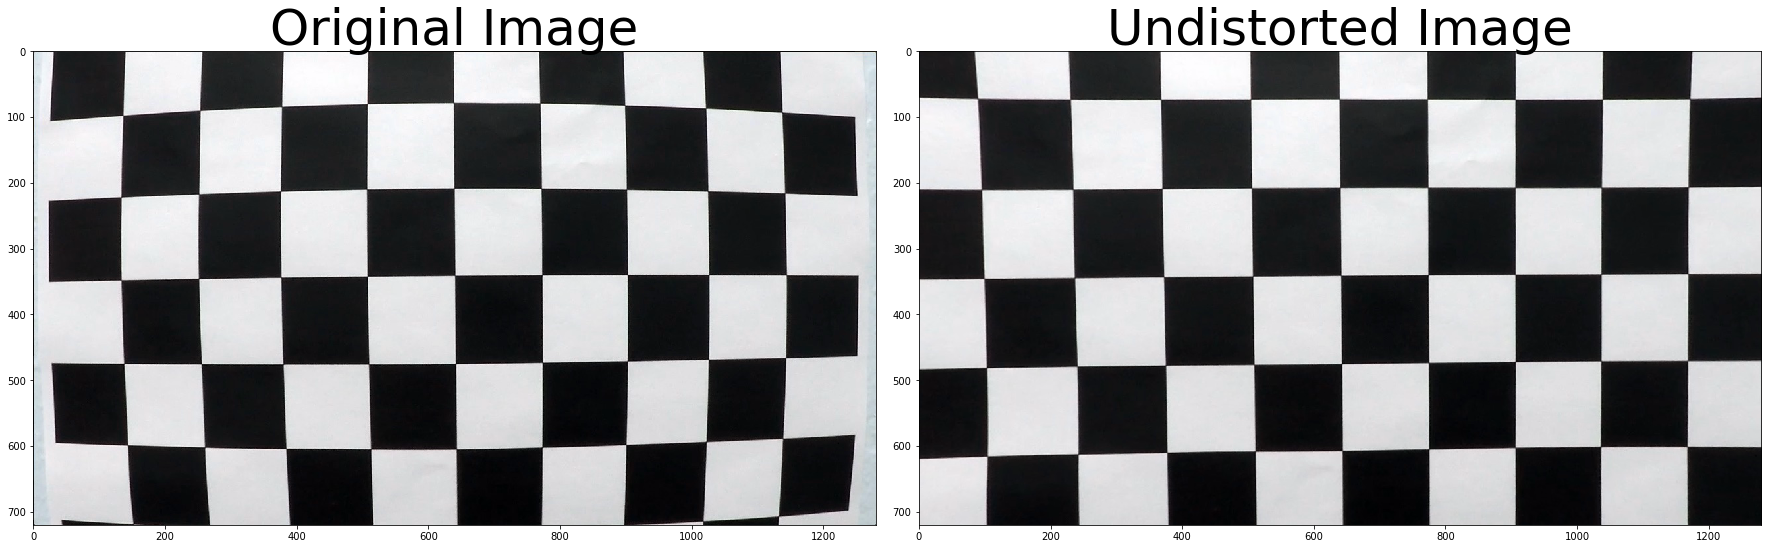

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')
mtx, dist = get_camera_calibration(img, objpoints, imgpoints)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
def get_undistorted_image(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

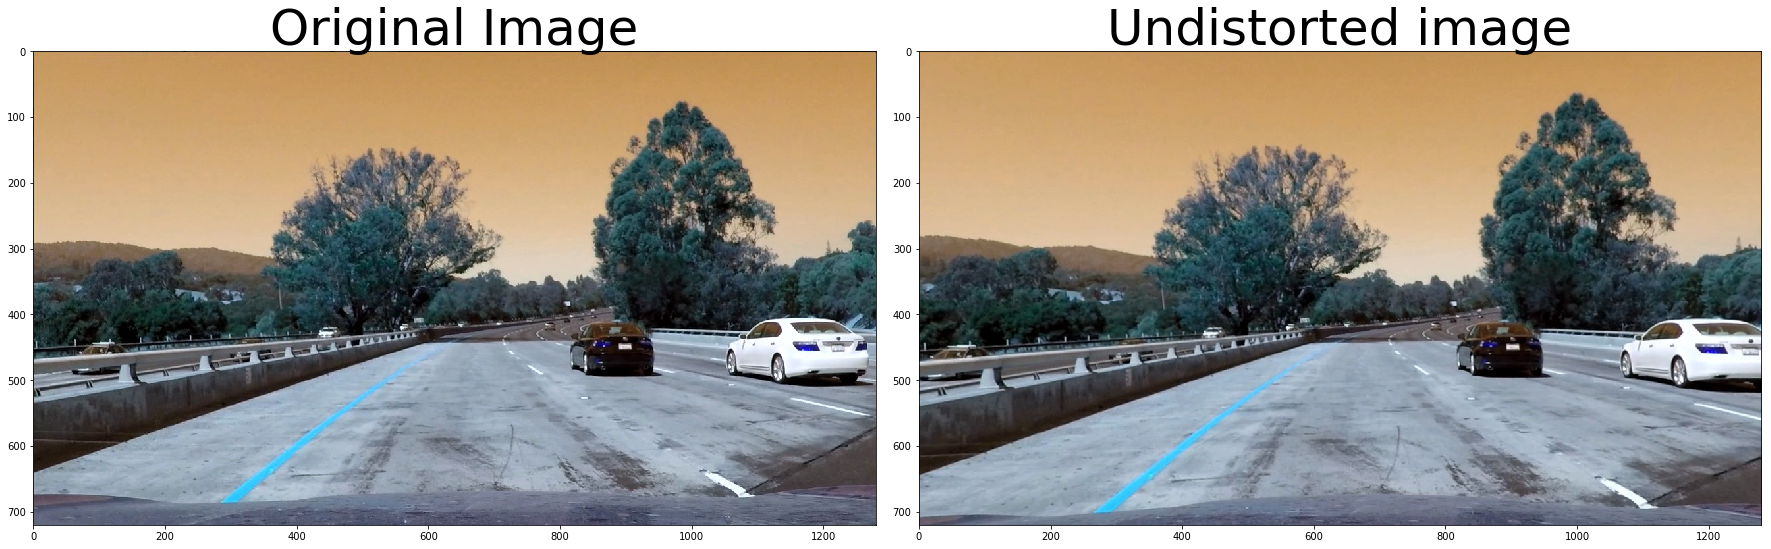

In [6]:
img = cv2.imread('test_images/test1.jpg')
undist_img = get_undistorted_image(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_img)
ax2.set_title('Undistorted image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [7]:
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    thresh_min, thresh_max = thresh
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    masked_sobel = np.zeros_like(scaled_sobel)
    masked_sobel[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return masked_sobel

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel_mag = np.sqrt(np.power(sobel_x, 2)+np.power(sobel_y, 2))
    sobel_scaled = np.uint8(255*sobel_mag/np.max(sobel_mag))
    sobel_mask = np.zeros_like(sobel_scaled)
    sobel_mask[(sobel_scaled>mag_thresh[0]) & (sobel_scaled<mag_thresh[1])] =1
    return sobel_mask

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    grad_dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir > thresh[0]) & (grad_dir < thresh[1])] = 1
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s>thresh[0]) & (s<=thresh[1])] = 1
    return binary_output

def get_thresholded_binary_image(image, ksize = 15):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    hls_binary = hls_select(image, thresh=(120, 255))
    combined = np.zeros_like(dir_binary)
    combined[ ((dir_binary == 1) &(grady==1) &(mag_binary==1)) |(hls_binary==1) ] = 1
    return combined


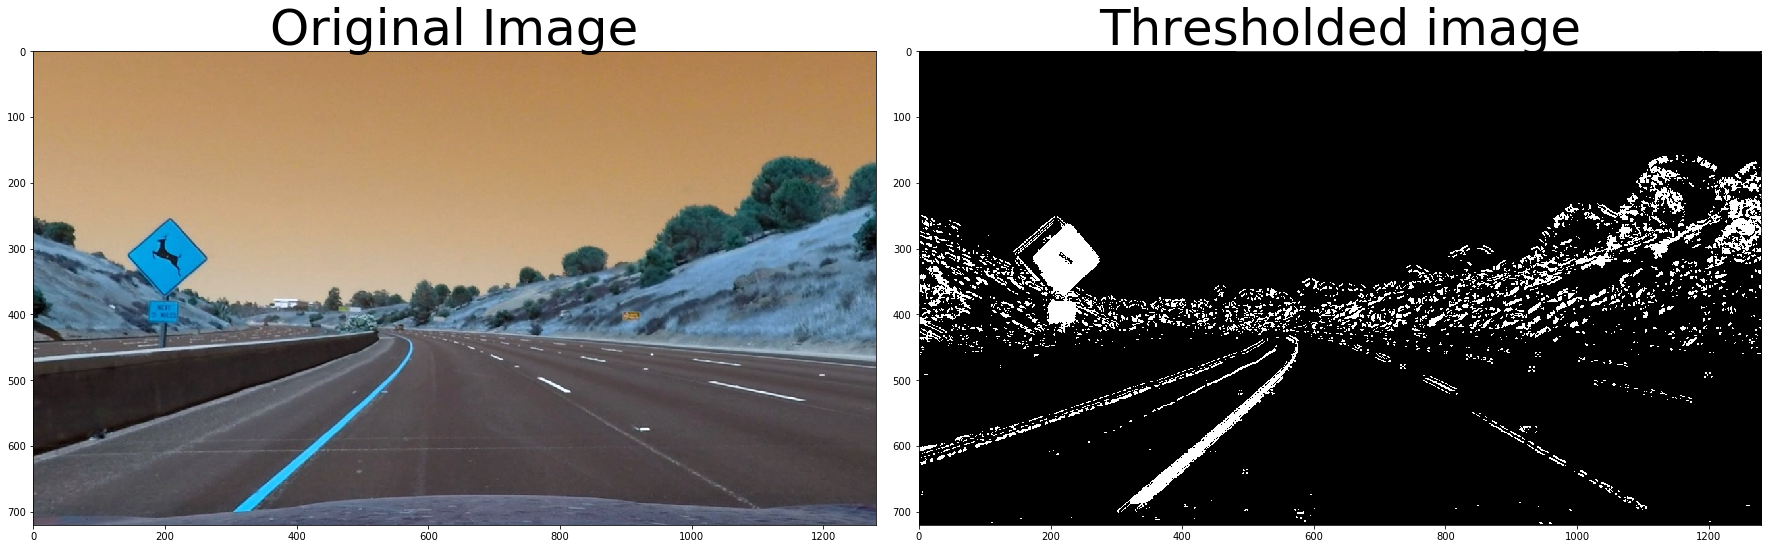

In [8]:
image = cv2.imread('test_images/test2.jpg')
undist_img = get_undistorted_image(image, mtx, dist)
combined = get_thresholded_binary_image(undist_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [9]:
def get_warp_matrix(undist_img):
    gray = cv2.cvtColor(undist_img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[img_size[0]//7+20,img_size[1]],#img_size[0]//7, img_size[1]],
                      [(6*img_size[0])//7+30, img_size[1]],
                      [img_size[0]//2+60, img_size[1]//2+100],
                      [img_size[0]//2-60, img_size[1]//2+100]])
    print(src)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    offset=200
    dst = np.float32([[offset, img_size[1]], 
                     [img_size[0]-offset, img_size[1]],
                     [img_size[0]-offset,0],
                     [offset, 0]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist_img, M, img_size)
    return warped, M, Minv, src, dst

[[  202.   720.]
 [ 1127.   720.]
 [  700.   460.]
 [  580.   460.]]


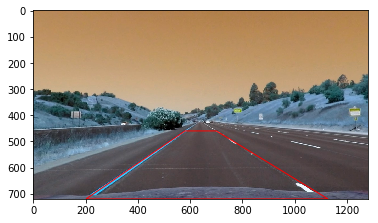

In [10]:
image = cv2.imread('test_images/straight_lines1.jpg')
undist_img = get_undistorted_image(image, mtx, dist)
warped_img, perspective_M, _, src, _ = get_warp_matrix(undist_img)
fig, ax = plt.subplots()
ax.imshow(undist_img)
rect = patches.Polygon(np.array(src), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

[[  202.   720.]
 [ 1127.   720.]
 [  700.   460.]
 [  580.   460.]]


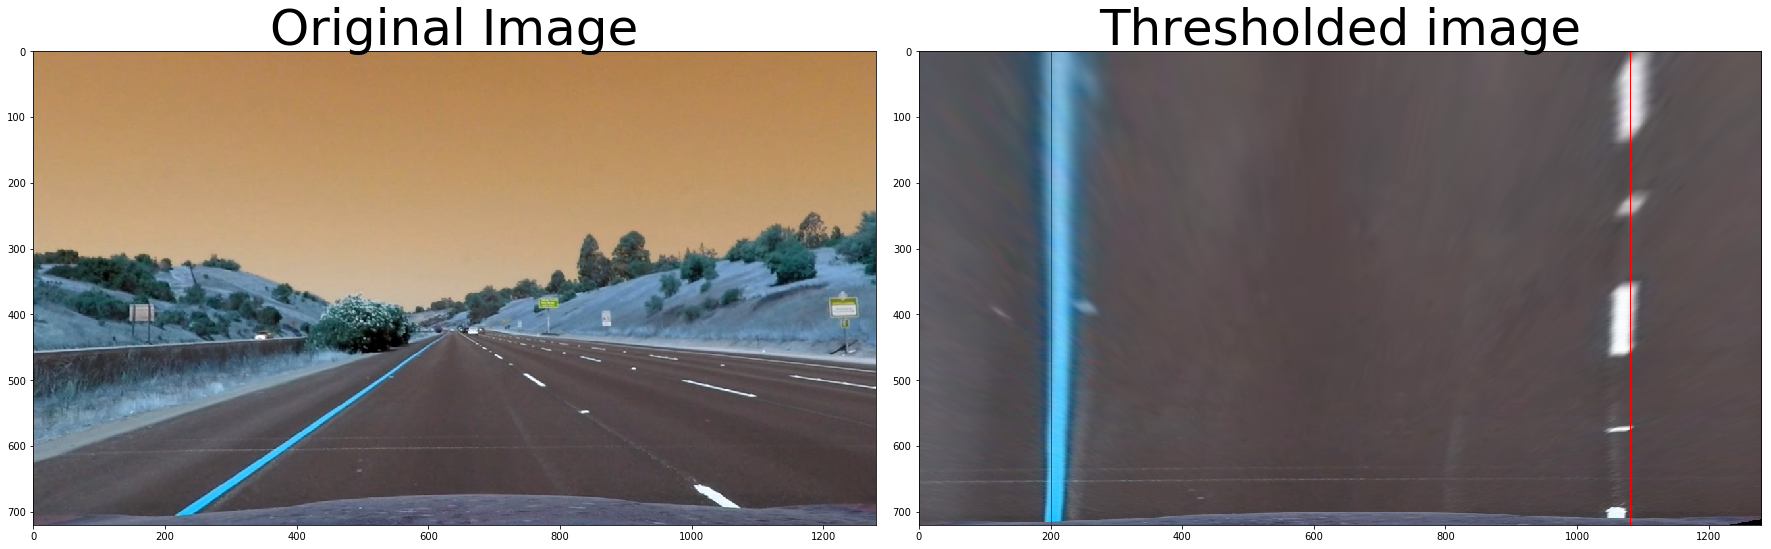

In [11]:
image = cv2.imread('test_images/straight_lines1.jpg')
undist_img = get_undistorted_image(image, mtx, dist)
warped_img, perspective_M, perspective_Minv, _, dst = get_warp_matrix(undist_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_img)
rect = patches.Polygon(np.array(dst), linewidth=1, edgecolor='r', facecolor='none')
ax2.add_patch(rect)
ax2.set_title('Thresholded image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [12]:
#perspective_M, perspective_Minv
def get_transformed_image(img, perspective_M):
    img_size = (img.shape[1], img.shape[0])
    warped_img = cv2.warpPerspective(img, perspective_M, img_size)
    return warped_img

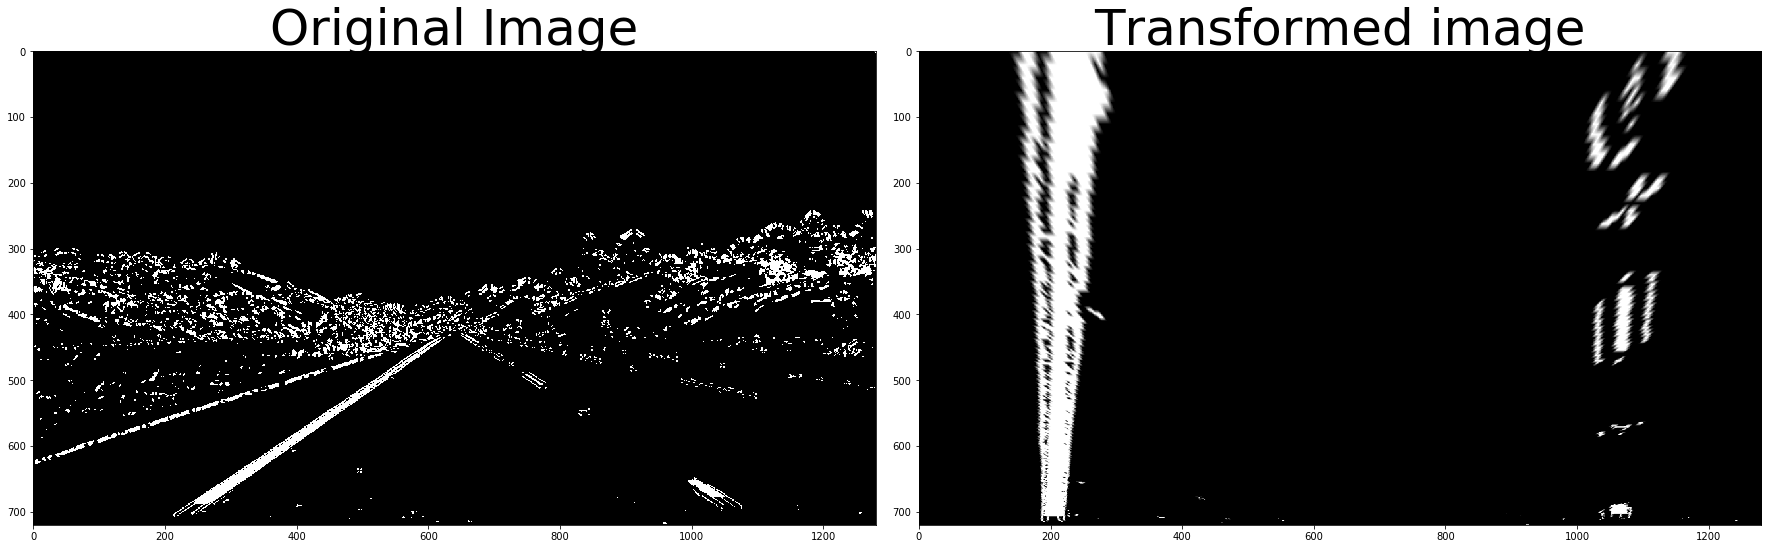

In [13]:
image = cv2.imread('test_images/straight_lines1.jpg')
undist_img = get_undistorted_image(image, mtx, dist)
combined = get_thresholded_binary_image(undist_img)

warped_img = get_transformed_image(combined, perspective_M)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Transformed image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [14]:
def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds =((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds)>minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        
        if len(good_right_inds)>minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    binary_warped = binary_warped.copy()
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, ploty, left_fitx, right_fitx



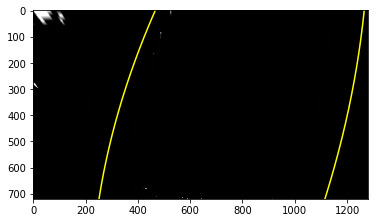

In [39]:
image = cv2.imread('test_images/test6.jpg')
undist_img = get_undistorted_image(image, mtx, dist)
combined = get_thresholded_binary_image(undist_img)
warped_img = get_transformed_image(combined, perspective_M)
out_img, left_fit, right_fit, ploty, left_fitx, right_fitx = fit_polynomial(warped_img)
plt.imshow(out_img)

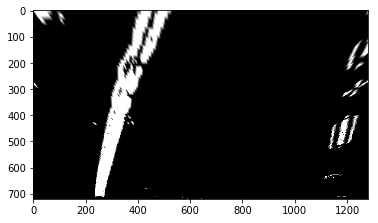

In [16]:
plt.imshow(warped_img, cmap='gray')

In [17]:
left_fit, right_fit

(array([  1.95586780e-04,  -4.39215746e-01,   4.66293416e+02]),
 array([ -1.46956285e-04,  -1.02816136e-01,   1.26540910e+03]))

In [18]:

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # left_fitx = None
    # right_fitx = None
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    binary_warped = binary_warped.copy()
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty , left_fit, right_fit= fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty, left_fit, right_fit



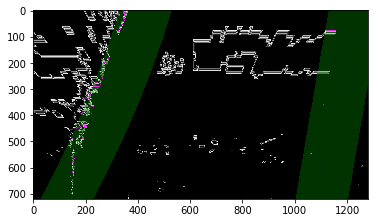

In [19]:
image = cv2.imread('test_images/test5.jpg')
undist_img = get_undistorted_image(image, mtx, dist)
combined = get_thresholded_binary_image(undist_img)
warped_img = get_transformed_image(combined, perspective_M)
result, left_fitx, right_fitx, ploty, left_fit, right_fit = search_around_poly(warped_img, left_fit, right_fit)

# View your output
plt.imshow(result)

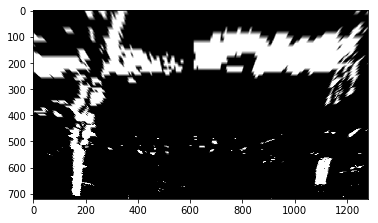

In [20]:
plt.imshow(warped_img, cmap='gray')

In [21]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = np.power(1+(2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2, 3/2)/(2*np.absolute(left_fit_cr[0]))  ## Implement the calculation of the left line here
    right_curverad = np.power(1+(2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2, 3/2)/(2*np.absolute(right_fit_cr[0])) ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


In [22]:
def plot_lanes(warped, undist, left_Fit, right_fit, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

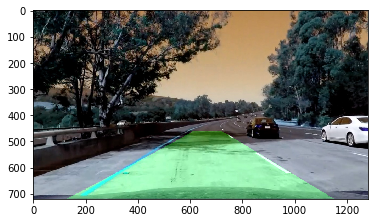

In [23]:
plt.imshow(plot_lanes(warped_img, undist_img, left_fitx, right_fitx, ploty, perspective_Minv))

In [24]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [33]:
class Pipeline():
    
    def __init__(self):
        self.mtx = mtx
        self.dist = dist
        self.perspective_M = perspective_M
        self.perspective_Minv = perspective_Minv
        self.left_lines = []
        self.right_lines = []
        self.xm_per_pix = 3.7/700
        self.ym_per_pix = 30/720 
    
    def get_undistorted_image(self, img):
        undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return undist

    def get_thresholded_binary_image(self, image, ksize = 15):
        gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
        grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
        mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
        dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
        hls_binary = hls_select(image, thresh=(120, 255))
        combined = np.zeros_like(dir_binary)
        combined[ ((dir_binary == 1) &(grady==1) &(mag_binary==1)) |(hls_binary==1) ] = 1
        return combined
    
    def get_transformed_image(self, img):
        img_size = (img.shape[1], img.shape[0])
        warped_img = cv2.warpPerspective(img, self.perspective_M, img_size)
        return warped_img
    
    def get_vehicle_offset(self, left_fitx, right_fitx, img_size):
        left_dist = img_size[1]//2 - left_fitx[-1]
        right_dist = right_fitx[-1] - img_size[1]//2
        #(right_fitx[-1] - left_fitx[-1])*xm_per_pix
        return left_dist, right_dist
    
    def check_last_line(self):
        if abs(self.left_lines[-1].radius_of_curvature - self.right_lines[-1].radius_of_curvature) > 200:
            flag = False
        else:
            dist_bet_lines = self.left_lines[-1].line_base_pos + self.left_lines[-1].line_base_pos
            if  dist_bet_lines > 1000 or dist_bet_lines < 1:#change this values later
                flag = False
            else:
                flag = True#Add function to check if lanes are parallel
        return flag
            
    
    def get_lines_from_scratch(self, warped_img, undist_img):
        out_img, left_fit, right_fit, ploty, left_fitx, right_fitx = fit_polynomial(warped_img)
        new_left_line = Line()
        new_right_line = Line()
        new_left_line.current_fit = left_fit
        new_right_line.current_fit = right_fit
        left_radius, right_radius = measure_curvature_real(ploty, left_fit, right_fit)
        new_left_line.radius_of_curvature = left_radius
        new_right_line.radius_of_curvature = right_radius
        left_dist, right_dist = self.get_vehicle_offset(left_fitx, right_fitx, warped_img.shape)
        new_left_line.line_base_pos = left_dist
        new_right_line.line_base_pos = right_dist
        new_left_line.allx = left_fitx
        new_left_line.ally = ploty
        new_right_line.allx = right_fitx
        new_right_line.ally = ploty
        self.left_lines.append(new_left_line)
        self.right_lines.append(new_right_line)
        #result = plot_lanes(warped_img, undist_img, left_fit, right_fit, ploty, self.perspective_Minv)
        return out_img
    
    def get_lines_from_previous(self, warped_img, undist_img, flag):
        result, left_fitx, right_fitx, ploty, left_fit, right_fit = search_around_poly(warped_img, 
                                                                                       self.left_lines[-1].current_fit,
                                                                                      self.right_lines[-1].current_fit)
        new_left_line = Line()
        new_right_line = Line()
        if flag:
            new_left_line.detected=True
            new_right_line.detected = True
        
        new_left_line.current_fit = left_fit
        new_right_line.current_fit = right_fit
        left_radius, right_radius = measure_curvature_real(ploty, left_fit, right_fit)
        new_left_line.radius_of_curvature = left_radius
        new_right_line.radius_of_curvature = right_radius
        left_dist, right_dist = self.get_vehicle_offset(left_fitx, right_fitx, warped_img.shape)
        new_left_line.line_base_pos = left_dist
        new_right_line.line_base_pos = right_dist
        new_left_line.allx = left_fitx
        new_left_line.ally = ploty
        new_right_line.allx = right_fitx
        new_right_line.ally = ploty
        self.left_lines.append(new_left_line)
        self.right_lines.append(new_right_line)
        result = plot_lanes(warped_img, undist_img, left_fit, right_fit, ploty, self.perspective_Minv)
        return result

    def process_frame(self, image):
        #plt.imshow(image)
        undist_img = self.get_undistorted_image(image)
        combined = self.get_thresholded_binary_image(undist_img)
        warped_img = self.get_transformed_image(combined)
        result = self.get_lines_from_scratch(warped_img, undist_img)
        return result
#         if len(self.left_lines) == 0:
#             result = self.get_lines_from_scratch(warped_img, undist_img)
#             return result
#         else:
#             flag = self.check_last_line
#             if not flag:
#                 result = self.get_lines_from_scratch(warped_img, undist_img)
#                 return result
#             else:
#                 result = self.get_lines_from_previous(warped_img, undist_img, flag)
#                 return result
            
            
            
            

In [34]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [37]:
pipeline_object = Pipeline()

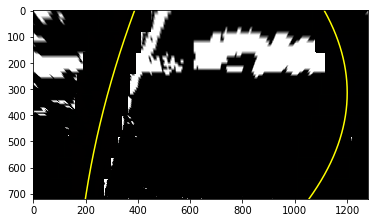

In [38]:
img = cv2.imread('test_images/test6.jpg')
result = pipeline_object.process_frame(img)
plt.imshow(result)

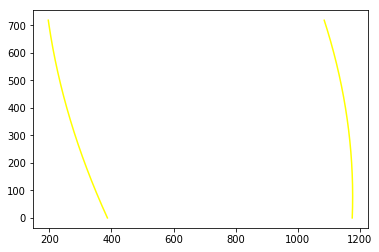

In [31]:
img = cv2.imread('test_images/test3.jpg')
#plt.imshow(img)
result = pipeline_object.process_frame(img)
#plt.imshow(result)

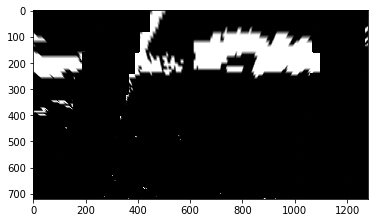

In [32]:
plt.imshow(result)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 96%|█████████▌| 25/26 [00:08<00:00,  3.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7.62 s, sys: 64.5 ms, total: 7.68 s
Wall time: 9 s


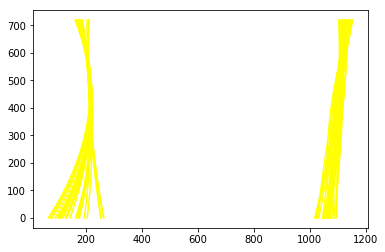

In [173]:
pipeline_object = Pipeline()
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(0, 1)
white_clip = clip1.fl_image(pipeline_object.process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [175]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))